# Relationship between TIVT/IVTmax and IVT variability

In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Change path to working script directory
current_path=os.getcwd()
print(current_path)
major_path = os.path.abspath("../../../")
base_working_path=major_path+"/my_GIT/Synthetic_Airborne_Arctic_ARs"
aircraft_base_path=major_path+"/Work/GIT_Repository/"
working_path  = base_working_path+"/src/"
config_path   = base_working_path+"/config/"
plotting_path = base_working_path+"/plotting/"

sys.path.insert(1, os.path.join(sys.path[0], working_path))
sys.path.insert(2, os.path.join(sys.path[0], config_path))
sys.path.insert(3, os.path.join(sys.path[0], plotting_path))

print(working_path)
os.chdir(working_path)


C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\Synthetic_Airborne_Arctic_ARs\notebooks
C:\Users\u300737\Desktop\PhD_UHH_WIMI/my_GIT/Synthetic_Airborne_Arctic_ARs/src/


In [3]:
import flightcampaign as Campaign
import flightmapping# as RFmaps
import flight_track_creator
import data_config

In [4]:
# Config File
config_file=data_config.load_config_file(aircraft_base_path,"data_config_file")
analyse_all_flights=False
flight_dates={"North_Atlantic_Run":
              {"SRF02":"20180224",
               "SRF04":"20190319",#},
               "SRF07":"20200416",#},
               "SRF08":"20200419"
              },
              "Second_Synthetic_Study":
              {"SRF02":"20110317",
               "SRF03":"20110423",
               "SRF08":"20150314",
               "SRF09":"20160311",
               "SRF12":"20180225"
               }}
flight_tracks_dict={}
campaigns=[*flight_dates.keys()]
shifted_lat=0
shifted_lon=0
ar_of_day="SAR_internal"

C:\Users\u300737\Desktop\PhD_UHH_WIMI/Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\PhD_UHH_WIMI/Work/GIT_Repository//data_config_file.ini.ini  already exists


In [5]:
import flight_track_creator

In [6]:
import atmospheric_rivers
import gridonhalo
from reanalysis import ERA5,CARRA
import ivtvariability as IVT_handler
from ivtvariability import IVT_variability

## Open IVT stats

In [7]:
ivt_stats_path="C://Users//u300737//Desktop//PhD_UHH_WIMI//Work//GIT_Repository//Second_Synthetic_Study/data//"
ivt_stats_file="IVT_Stats_Overall_all_RFs.csv"
ivt_stats=pd.read_csv(ivt_stats_path+ivt_stats_file,index_col=0)
ivt_stats

,flight,TIVT,IVT_max,IVT_std
0,20180224_inflow,17.570328,441.229745,102.904870
1,20180224_outflow,17.570328,448.727767,105.416993
2,20190319_inflow,16.640991,323.601151,80.951611
3,20190319_outflow,16.640991,280.738482,76.896191
4,20200416_inflow,15.157532,314.351979,47.050435
5,20200416_outflow,15.157532,321.739834,53.332170
6,20200419_inflow,16.605099,444.182968,106.817795
7,20200419_outflow,16.605099,386.393130,93.015865
8,20110317_inflow,28.058089,520.075342,123.571844
9,20110317_outflow,28.058089,488.168162,122.188618


## Load TIVT soundings

In [8]:
TIVT_dict={}
p=0
for campaign in flight_dates.keys():
    for flight in flight_dates[campaign]:
        date=flight_dates[campaign][flight]
        if campaign=="Second_Synthetic_Study":
            cmpgn_cls=Campaign.Second_Synthetic_Study(
                             is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])               
        else:
            cmpgn_cls=Campaign.North_Atlantic_February_Run(is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])
        TIVT_sounding_data_path=cmpgn_cls.campaign_data_path
        TIVT_sounding_inflow_filename="SAR_internal_"+flight+"_inflow_TIVT_Sonde_Resolution.csv"
        TIVT_sounding_outflow_filename="SAR_internal_"+flight+"_outflow_TIVT_Sonde_Resolution.csv"
        TIVT_dict[flight_dates[campaign][flight]+"_inflow"]=pd.read_csv(TIVT_sounding_data_path+\
                                                                       TIVT_sounding_inflow_filename,index_col=0)
        TIVT_dict[flight_dates[campaign][flight]+"_outflow"]=pd.read_csv(TIVT_sounding_data_path+\
                                                                       TIVT_sounding_outflow_filename,index_col=0)
        TIVT_dict[flight_dates[campaign][flight]+"_inflow"]["IVT_max"]=\
                ivt_stats["IVT_max"].iloc[2*p]
        TIVT_dict[flight_dates[campaign][flight]+"_outflow"]["IVT_max"]=\
                ivt_stats["IVT_max"].iloc[2*p+1]
        
        if p==0:
            TIVT_df=TIVT_dict[flight_dates[campaign][flight]+"_inflow"]
            TIVT_df=TIVT_df.append(TIVT_dict[flight_dates[campaign][flight]+"_outflow"])
        else:
            TIVT_df=TIVT_df.append(TIVT_dict[flight_dates[campaign][flight]+"_inflow"])
            TIVT_df=TIVT_df.append(TIVT_dict[flight_dates[campaign][flight]+"_outflow"])
        p+=1

Overall directory of campaign work is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository/NA_February_Run/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository/NA_February_Run/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository/NA_February_Run/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository/NA_February_Run/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository/Second_Synthetic_Study/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository/Second_Synthetic_Study/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository/Second_Synthetic_Study/
Overall directory of campaign work is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository/Second_Synthetic_Study/
Overall directory of campaign work is:  C:\Users\u30

In [9]:
rel_TIVT_df=TIVT_df.iloc[:,0:8]#/TIVT_df["REAL-CARRA-TIVT"]
#rel_TIVT_df
for idx in range(rel_TIVT_df.shape[0]):
    rel_TIVT_df.iloc[idx,:]=(rel_TIVT_df.iloc[idx,:]-float(TIVT_df["REAL-CARRA-TIVT"].iloc[idx]))/\
                                float(TIVT_df["REAL-CARRA-TIVT"].iloc[idx])
rel_TIVT_df.index=range(rel_TIVT_df.shape[0])
TIVT_df.index=range(TIVT_df.shape[0])
rel_TIVT_df["IVT_max"]=TIVT_df["IVT_max"]
rel_TIVT_df["REAL-CARRA-TIVT"]=TIVT_df["REAL-CARRA-TIVT"]

print(TIVT_df.columns)

#TIVT_df["IVT_max"].describe()["25%"]
# quantile_variable to analyse
quantile_variable="IVT_max"#"REAL-CARRA-TIVT"
weak_index=rel_TIVT_df[rel_TIVT_df[quantile_variable]<rel_TIVT_df[quantile_variable].describe()["25%"]]
strong_index=rel_TIVT_df[rel_TIVT_df[quantile_variable]>rel_TIVT_df[quantile_variable].describe()["75%"]]

Index(['300s', '360s', '480s', '600s', '720s', '900s', '1200s', '1500s',
       'REAL-CARRA-TIVT', 'cumsum_distance', 'IVT_max'],
      dtype='object')


Figure successfully saved as:  C:\Users\u300737\Desktop\PhD_UHH_WIMI/Work/Synthetic_AR_Paper/Manuscript/Paper_Plots/Fig09_CARRA_Synthetic_Sonde_Frequency_TIVT_BIAS_QIVT_max.png


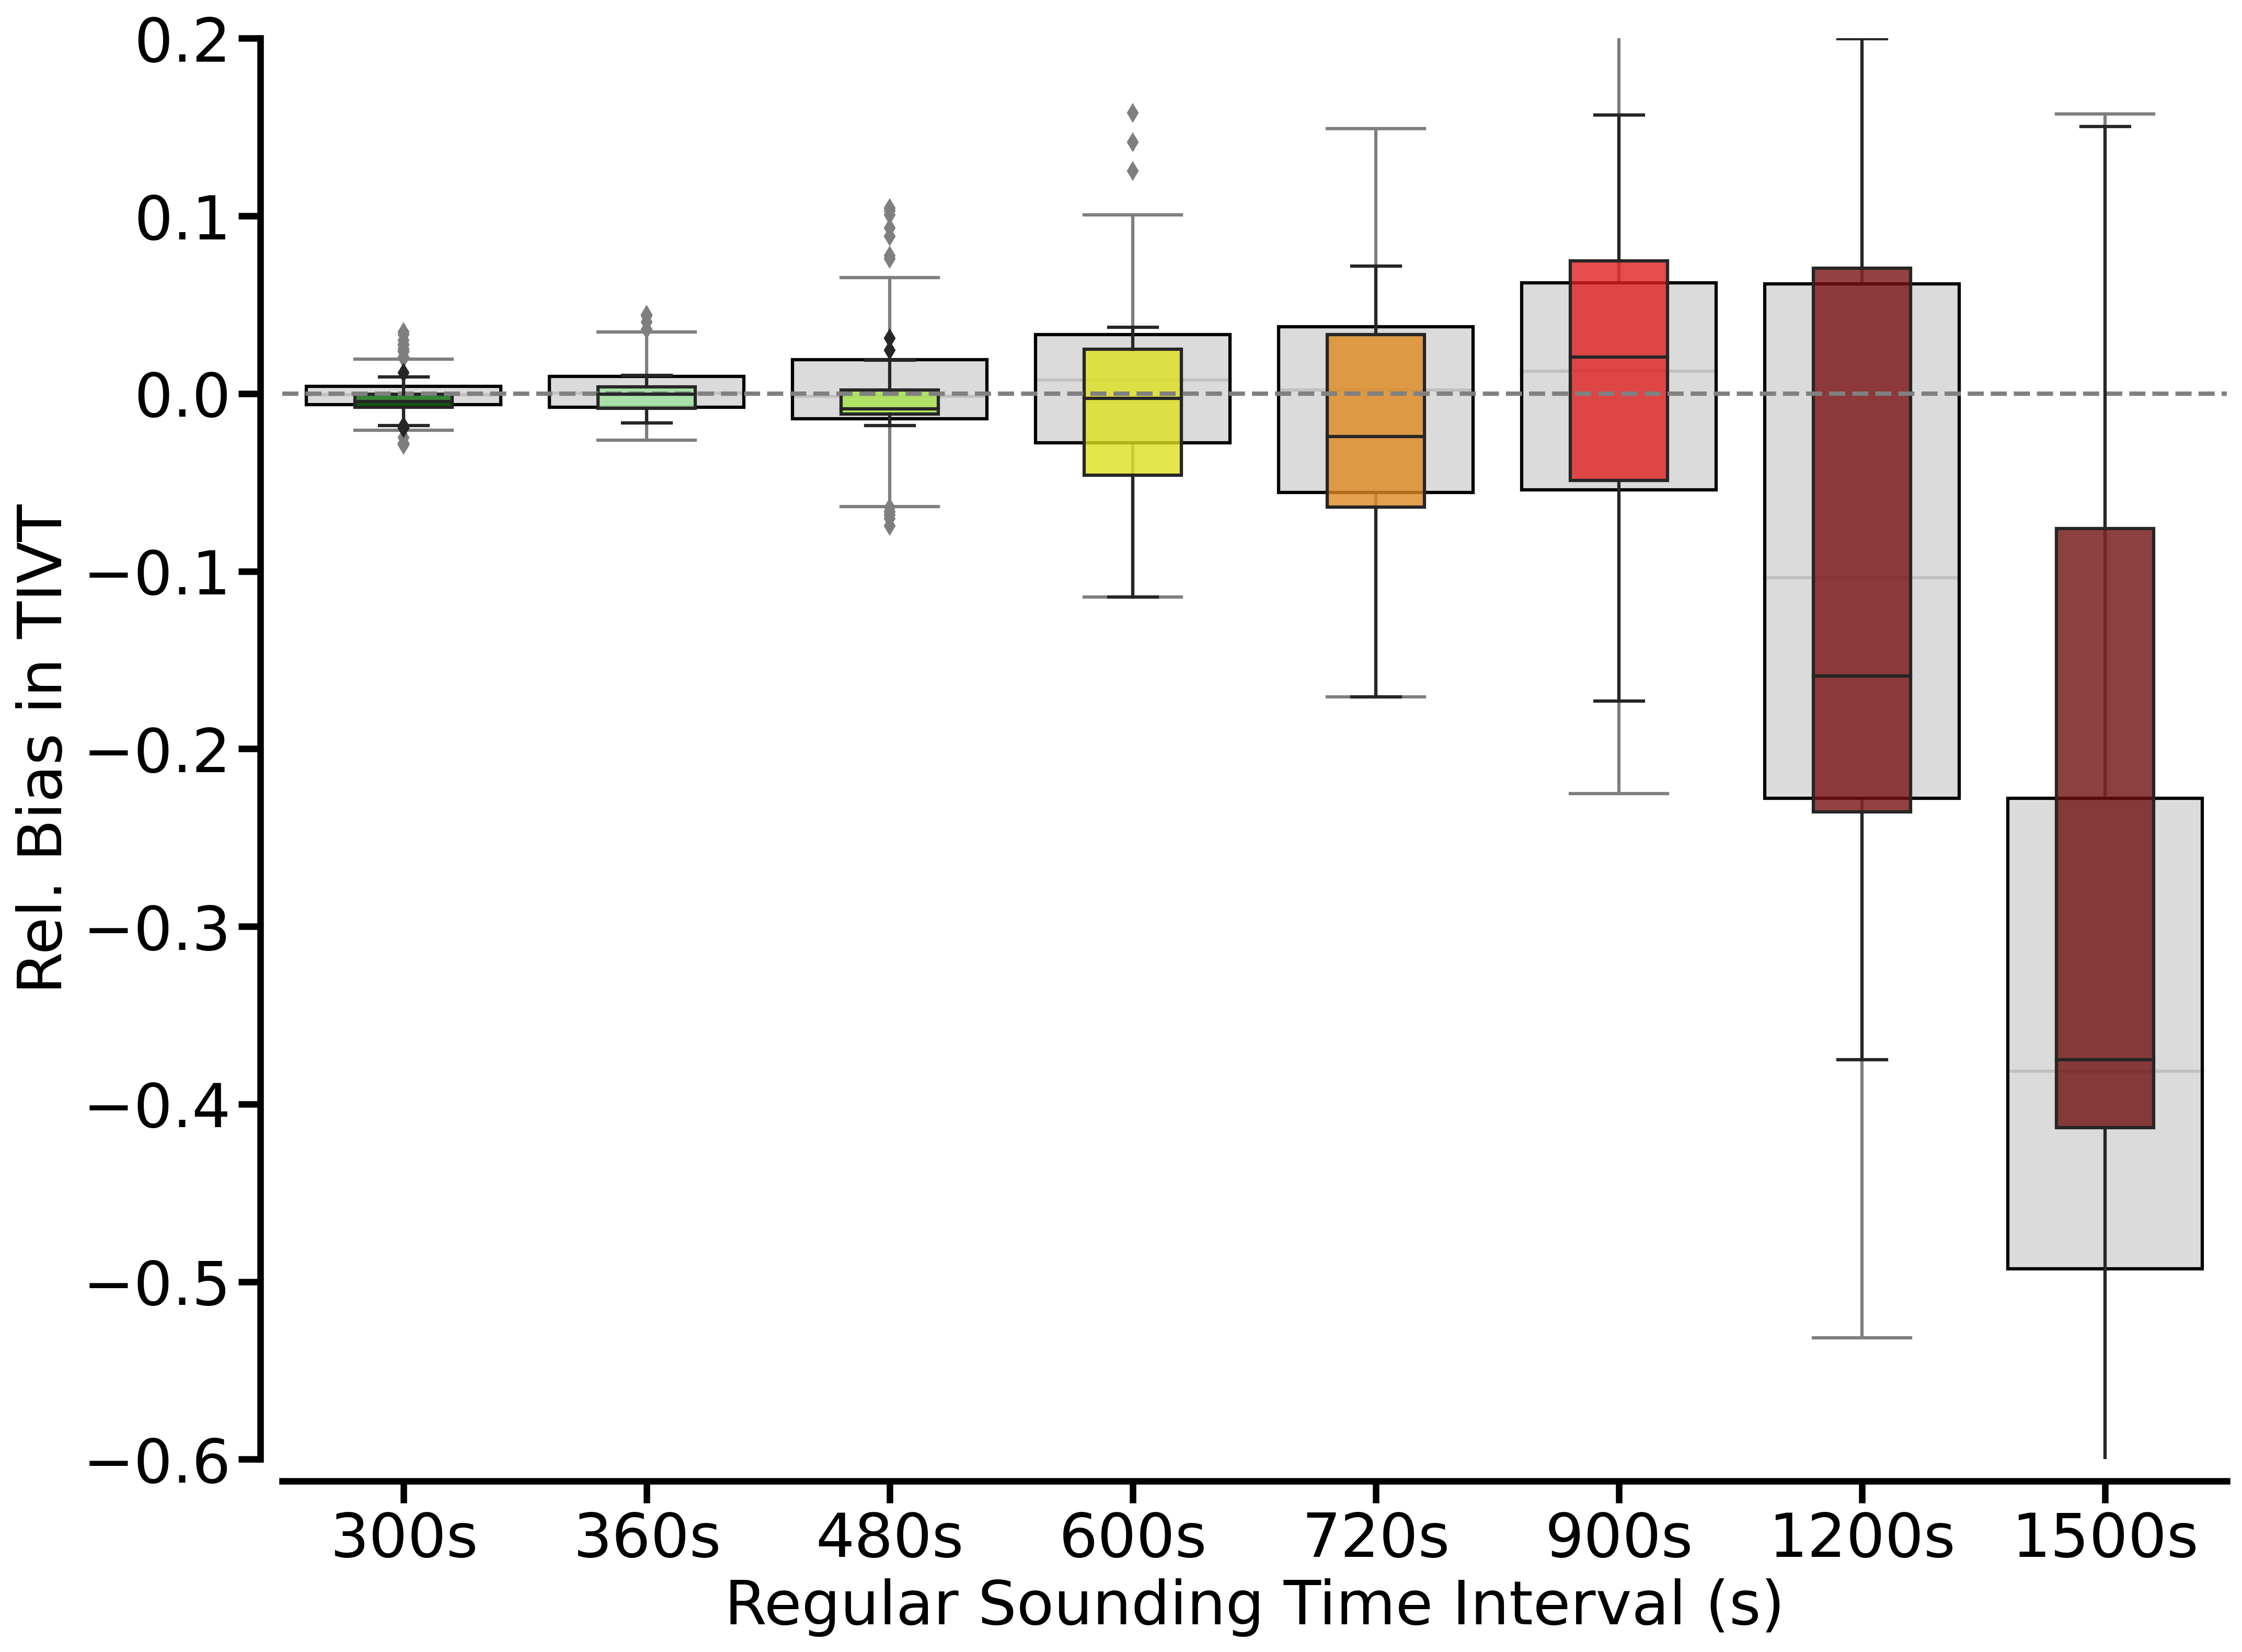

In [12]:
#sonde_numbers=[key for key in self.TIVT.keys() if "sondes_no" in key]
#error_columns=[int(col[9:]) for col in sonde_numbers]
#error_columns=np.sort(error_columns)
#errors=pd.DataFrame(data=np.nan,index=self.TIVT["sondes_no9"].index,
#                 columns=[str(err) for err in error_columns])
#for num in errors.columns:
#    errors[num]=self.TIVT["sondes_no"+num]["Rel_BIAS"]
#Start plotting
from matplotlib import ticker as tick
import seaborn as sns
#Start plotting
sonde_freq_fig=plt.figure(figsize=(16,12), dpi= 300)
matplotlib.rcParams.update({'font.size': 28})
x_var = 'Sounding distance in AR Cross-Section'
colors= {"1500s":"maroon","1200s":"darkred",
         "900s":"red","720s":"darkorange",
         "600s":"yellow","480s":"greenyellow",
         "360s":"lightgreen","300s":"green"}
ax1=sonde_freq_fig.add_subplot(111)
ax1.axhline(0,color="grey",ls="--",lw=2,zorder=1)
colors_taken           = [colors[sonde_no] for sonde_no in colors.keys()]
#print()
boxes=sns.boxplot(data=rel_TIVT_df.iloc[:,:-1],color="lightgrey",#palette=colors_taken[::-1], 
                        notch=False,zorder=0)
plt.setp(boxes.artists, edgecolor = 'k', facecolor='lightgrey')

strong_boxes=sns.boxplot(data=strong_index.iloc[:,:-2],width=0.4,palette=colors_taken[::-1],notch=False,zorder=1)
# iterate over boxes
for patch in strong_boxes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .8))
for axis in ["left","bottom"]:
    ax1.spines[axis].set_linewidth(3)
    ax1.xaxis.set_tick_params(width=3,length=10)
    ax1.yaxis.set_tick_params(width=3,length=10)
                
ax1.set_ylabel("Rel. Bias in TIVT")
ax1.set_xlabel("Regular Sounding Time Interval (s)")
sns.despine(offset=10)
#ax1.set_xlabel(x_var)
ax1.set_ylim([-0.6,0.2])
fig_name="Fig09_CARRA"+\
    "_Synthetic_Sonde_Frequency_TIVT_BIAS_Q"+quantile_variable+".png"
fig_path=major_path+"/Work/Synthetic_AR_Paper/Manuscript/Paper_Plots/"
sonde_freq_fig.savefig(fig_path+fig_name,dpi=200,bbox_inches="tight")
print("Figure successfully saved as: ",fig_path+fig_name)


## IVT Variability plots

Correlation R= 0.778387652916597


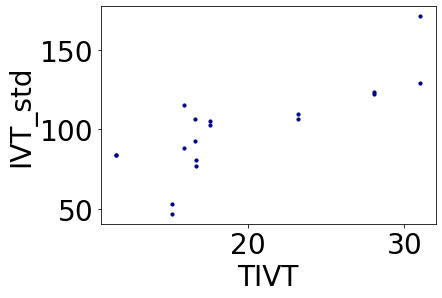

In [11]:
r=np.corrcoef(x=ivt_stats["TIVT"].astype(float),y=ivt_stats["IVT_std"].astype(float))
ivt_stats.plot.scatter(x="TIVT",y="IVT_std",s=10,color="darkblue")
print("Correlation R=",r[0,1])

Correlation R= 0.885118182201676


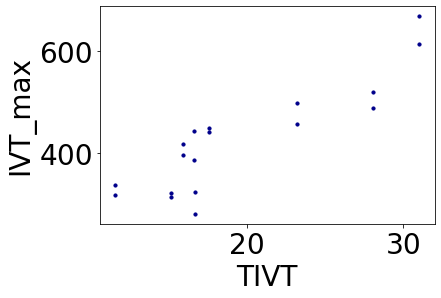

In [12]:
r=np.corrcoef(x=ivt_stats["TIVT"].astype(float),y=ivt_stats["IVT_max"].astype(float))
ivt_stats.plot.scatter(x="TIVT",y="IVT_max",s=10,color="darkblue")
print("Correlation R=",r[0,1])

Correlation R= 0.9130569008442379


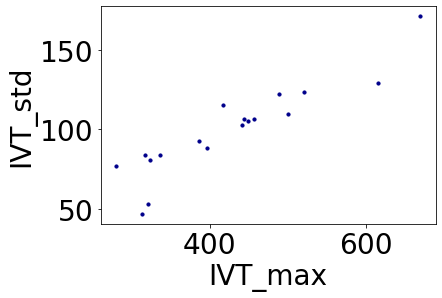

In [13]:
r=np.corrcoef(x=ivt_stats["IVT_max"].astype(float),y=ivt_stats["IVT_std"].astype(float))
ivt_stats.plot.scatter(x="IVT_max",y="IVT_std",s=10,color="darkblue")
print("Correlation R=",r[0,1])

In [14]:
ivt_var_plot_cls.plot_model_sounding_frequency_comparison(
                            name_of_grid_data="CARRA")

NameError: name 'ivt_var_plot_cls' is not defined

In [ ]:
r=np.corrcoef(x=ivt_stats["IVT_max"].astype(float),y=ivt_stats["TIVT"].astype(float))
ivt_stats.plot.scatter(x="IVT_max",y="TIVT",s=10,color="darkblue")
print("Correlation R=",r[0,1])